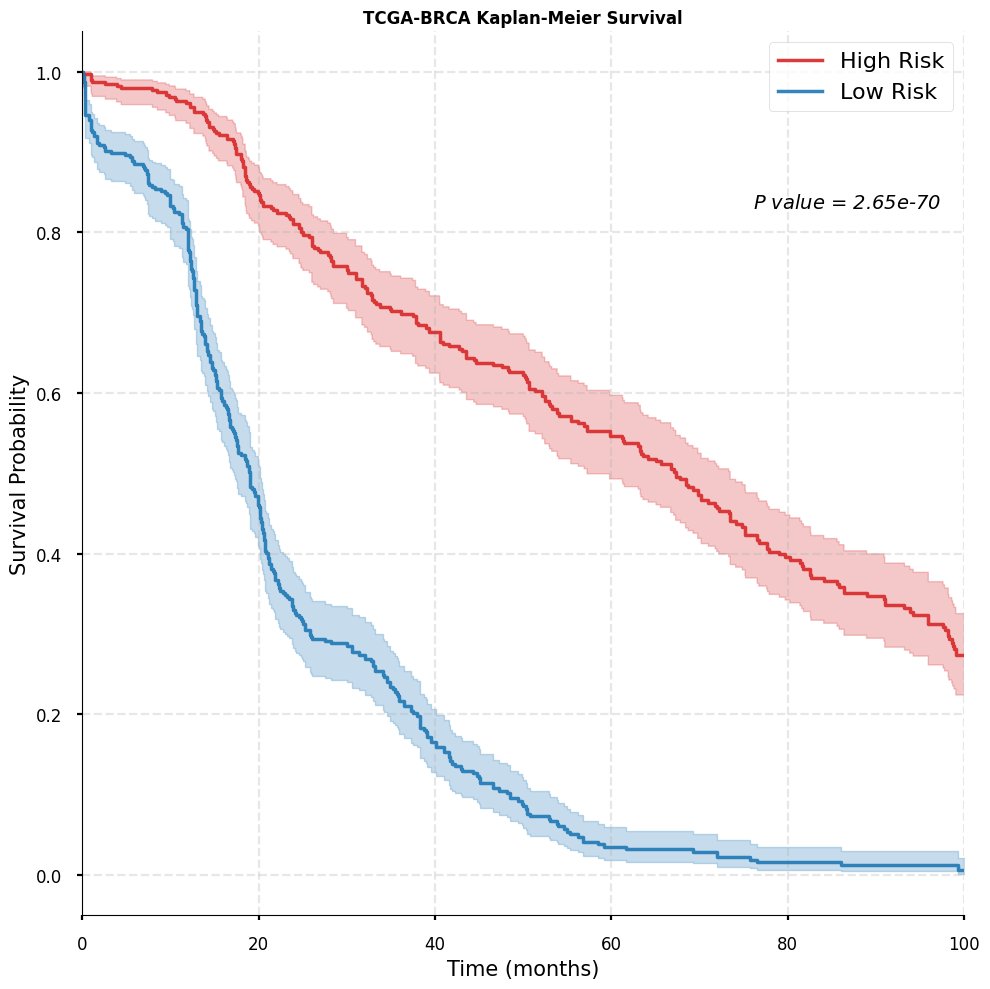

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

# 读取文件
pred_df = pd.read_csv("/home/yuhaowang/project/FMBC/downstream/finetune/outputs/TCGA-BRCA-SURVIVAL/FMBC/LR_Same_0.25_MeanPool/0.0001/prediction_results/val_survival_prediction.csv")  # 包含 slide_id, val_prob, val_time, val_event
label_df = pd.read_csv("/home/yuhaowang/project/FMBC/downstream/finetune/dataset_csv/survival/TCGA-BRCA-SURVIVAL.csv")      # 包含 slide_id, survival_months, censorship, etc.

# 合并数据
df = pd.merge(pred_df, label_df, on="slide_id", how="inner")
df.dropna(inplace=True, how='any', axis=0)


df.rename(columns={
    'val_prob': 'val_prob',
    'survival_months': 'val_time_months',
    'censorship': 'event'
}, inplace=True)

# 🧠 如果你的模型分数越低风险越高，这里要反转一下
df['risk_score'] = -df['val_prob']  # 🔁 修改这一步可根据你模型定义调整

# 🎯 增加组间差异（取前10% / 后10%）
q_low = df['risk_score'].quantile(0.4)
q_high = df['risk_score'].quantile(0.6)

low_risk = df[df['risk_score'] <= q_low].copy()
high_risk = df[df['risk_score'] >= q_high].copy()

# 合并
df_filtered = pd.concat([
    low_risk.assign(risk_group='Low Risk'),
    high_risk.assign(risk_group='High Risk')
])

# KM 拟合
kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(10, 10))

# 曲线拟合
kmf_high.fit(
    durations=high_risk['val_time_months'],
    event_observed=high_risk['event'],
    label='High Risk'
)
kmf_low.fit(
    durations=low_risk['val_time_months'],
    event_observed=low_risk['event'],
    label='Low Risk'
)

# 🎨 绘图（增加透明度/加宽线条/颜色增强）
kmf_high.plot(ax=ax, ci_show=True, linewidth=2.5, color='#d62728', alpha=0.9)
kmf_low.plot(ax=ax, ci_show=True, linewidth=2.5, color='#1f77b4', alpha=0.9)

# 🧮 log-rank 检验
results = logrank_test(
    high_risk['val_time_months'], low_risk['val_time_months'],
    event_observed_A=high_risk['event'],
    event_observed_B=low_risk['event']
)
p_val = results.p_value

# 📝 显示 P 值
plt.text(0.76, 0.8, f"$P$ value = {p_val:.2e}",
         transform=ax.transAxes, fontsize=14, style='italic')

# ✅ 只展示前100个月
plt.xlim(0, 100)

# 添加风险表
#add_at_risk_counts(kmf_high, kmf_low, ax=ax)

# 🎨 图形美化
plt.title('TCGA-BRCA Kaplan-Meier Survival',  fontsize=12, fontweight='bold')
plt.xlabel('Time (months)', fontsize=15)
plt.ylabel('Survival Probability', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
#plt.legend(title='Risk Group', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.style.use('seaborn-v0_8-poster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./results/TCGA-BRCA-Survival.png', dpi=1000, bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd

# 读取数据
pred_df = pd.read_csv("/home/yuhaowang/project/FMBC/downstream/finetune/outputs/TCGA-BRCA-SURVIVAL/FMBC/LR_Same_0.25_MeanPool/0.0001/prediction_results/val_survival_prediction.csv")
label_df = pd.read_csv("/home/yuhaowang/project/FMBC/downstream/finetune/dataset_csv/survival/TCGA-BRCA-SURVIVAL.csv")

# 对 slide_id 进行标准化（防止尾部空格或大小写不一致）
pred_df['slide_id'] = pred_df['slide_id'].str.strip()
label_df['slide_id'] = label_df['slide_id'].str.strip()

# 合并预测和标签
merged_df = pd.merge(pred_df, label_df, on='slide_id', how='inner')

# 构造目标格式
merged_df['sample'] = merged_df['slide_id']
merged_df['patient'] = merged_df['slide_id'].str.replace(r"-01$", "", regex=True)  # 去掉 -01 后缀作为 patient ID
merged_df['censor_state'] = merged_df['censorship']  # 原标签中的 censorship 表示是否终止（1终止，0未终止）
merged_df['survival_time_day'] = merged_df['OS_days']  # 使用真实生存天数
merged_df['Risk'] = pd.qcut(merged_df['val_prob'], q=2, labels=["low", "high"])  # 二分风险分层
merged_df['risk_score_scale'] = merged_df['val_prob']

# 保留目标列并排序
output_df = merged_df[['sample', 'patient', 'censor_state', 'survival_time_day', 'Risk', 'risk_score_scale']]
output_df.to_csv("/home/yuhaowang/project/FMBC/downstream/finetune/script/plot/survival/formatted_survival_analysis.csv", index=False)
print(output_df.head())


            sample       patient  censor_state  survival_time_day Risk  \
0  TCGA-5L-AAT1-01  TCGA-5L-AAT1             1               1470  low   
1  TCGA-A1-A0SD-01  TCGA-A1-A0SD             1                437  low   
2  TCGA-A1-A0SK-01  TCGA-A1-A0SK             0                966  low   
3  TCGA-A1-A0SQ-01  TCGA-A1-A0SQ             1                553  low   
4  TCGA-A2-A04X-01  TCGA-A2-A04X             1               1685  low   

   risk_score_scale  
0          1.827148  
1          1.408203  
2          1.068359  
3          1.999023  
4         -0.910156  


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ari

The number of sota tasks is 3,across 3 datasets
['GTEX_PROG']


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

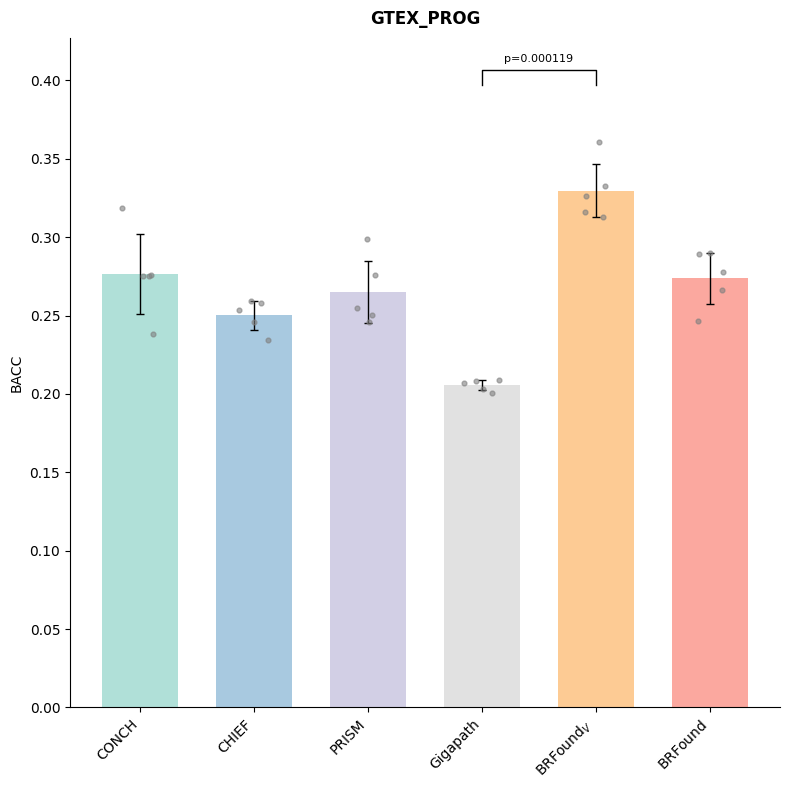

多子图绘制完成！


In [1]:
from utils import plot_tasks_grid
import os
# ---------------------------
# 使用示例（请根据需要启用/禁用）
# ---------------------------
total_task_list=os.listdir('/home/yuhaowang/project/FMBC/downstream/finetune/dataset_csv/survival')

total_task_list=[task[:-4] for task in total_task_list if task[-4:]=='.csv']
trash_task = ['DORID_2','POST-NAT-BRCA-3TYPE','BACH_TUMOR','AHSL-SUBTYPE','CPTAC-IDC']
#AHSL-SUBTYPE 现在别去定，重新拍一下
not_sota_task = ['CAMELYON16_TEST_IDC','BCNB_TUMOR','IMPRESS_RESIDUAL-TUMOR','BRACS_FINE','AHSL-GRADE-1','TUPAC_TUMOR_SCORE',
                 'AIDPATH_GRADE','CPTAC_IDC']#'AHSL_SUBTYPE',
not_good_task = ['POST-NAT-BRCA-HERIHC']
task_list = [task for task in total_task_list if task not in trash_task and task not in not_sota_task and task not in not_good_task]

print('The number of sota tasks is {0},across {1} datasets'.format(len(task_list),len(set([task.split('_')[0] for task in task_list]))))
task_list = ['GTEX_PROG']
if __name__ == "__main__":
    example_tasks = task_list
    print(task_list)
    plot_tasks_grid(
        tasks=example_tasks,
        evaluation_metric='val_bacc',
        compare_model='Gigapath',
        grid_shape=(1,1),
        font_family='Arial',
        wspace=0.4,
        hspace=0.4,
        tight_layout=True,
        figure_size=(8,8),
        csv_dir="/home/yuhaowang/project/FMBC/downstream/finetune/script/result/result_csv/learning_rate_select",
        result_path="/home/yuhaowang/project/FMBC/downstream/finetune/outputs",
        save_dir='./results',
        save_name='GTEX_Survival.png',
        bar_width=0.1,               # 控制单个柱子的宽度
        bar_gap=0.05,                 # 控制柱子之间的距离
        p_value_alternative='greater'  # 使用双边检验
    )

    print("多子图绘制完成！")


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

['TCGA-BRCA-SURVIVAL']


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

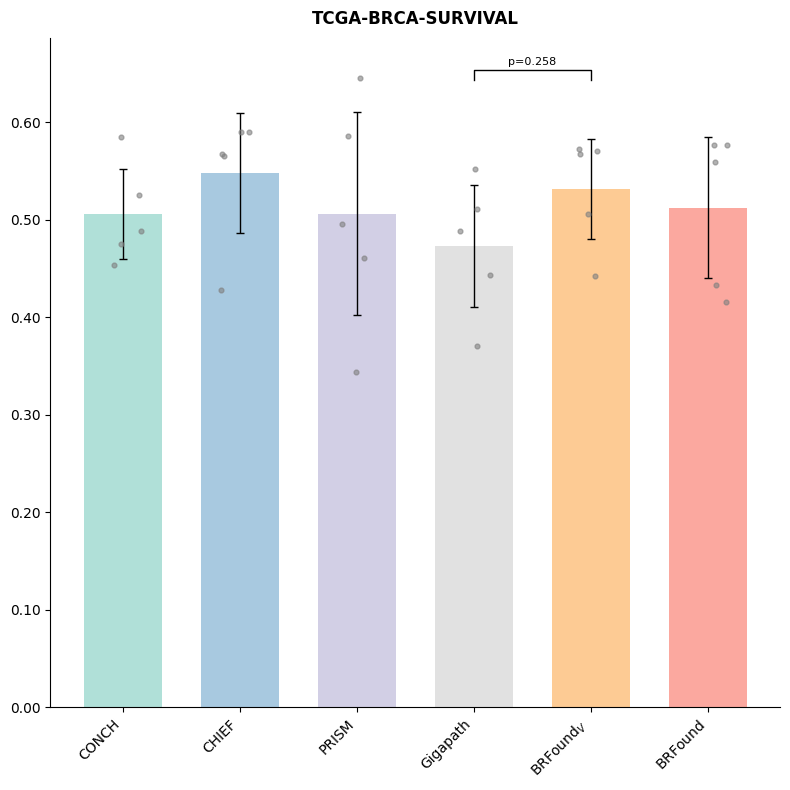

多子图绘制完成！


: 

In [ ]:
task_list = ['TCGA-BRCA-SURVIVAL']
if __name__ == "__main__":
    example_tasks = task_list
    print(task_list)
    plot_tasks_grid(
        tasks=example_tasks,
        evaluation_metric='val_c_index',
        compare_model='Gigapath',
        grid_shape=(1,1),
        font_family='Arial',
        wspace=0.4,
        hspace=0.4,
        tight_layout=True,
        figure_size=(8,8),
        csv_dir="/home/yuhaowang/project/FMBC/downstream/finetune/script/result/result_csv/learning_rate_select",
        result_path="/home/yuhaowang/project/FMBC/downstream/finetune/outputs",
        save_dir='./results',
        save_name='TCGA_Survival.png',
        bar_width=0.1,               # 控制单个柱子的宽度
        bar_gap=0.05,                 # 控制柱子之间的距离
        p_value_alternative='greater'  # 使用双边检验
    )

    print("多子图绘制完成！")